# LightGBM 

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import os
for dirname, _, filenames in os.walk('../data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/sample_submit.csv
../data/sumote_lightBGM1_0602.csv
../data/test.csv
../data/train.csv
../data/.ipynb_checkpoints\sample_submit-checkpoint.csv
../data/.ipynb_checkpoints\sumote_lightBGM1_0602-checkpoint.csv
../data/.ipynb_checkpoints\test-checkpoint.csv
../data/.ipynb_checkpoints\train-checkpoint.csv


In [31]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')
sample_sub = pd.read_csv('../data/sample_submit.csv', header=None)

# set type label
train_df['type'] = 'train'
test_df['type'] = 'test'

# all data
all_df = pd.concat([train_df, test_df], axis=0)

## 特徴量前処理

In [32]:
import re
from imblearn.over_sampling import SMOTE


def eda(all_df):
    # データの追加や削除
    return all_df


# カテゴリカル変数をOne-Hot_Encodingで変換
all_df = pd.get_dummies(all_df, columns=['sex', 'smoker', 'region'], drop_first=True)

# 特徴量の削除/追加
all_df = eda(all_df)

# trainとtestに分けなおす
train_df = all_df[all_df['type'] == 'train']
test_df = all_df[all_df['type'] == 'test']
# train正解ラベル
y = train_df['charges']

# 学習に不要な特徴量を削除
train_df = train_df.drop(columns=['id', 'charges', 'type'])
test_df = test_df.drop(columns=['id', 'charges', 'type'])

# オーバーサンプリング
# SMOTEの初期化と適用
smote = SMOTE(random_state=42)
train_df, y = smote.fit_resample(train_df, y)

"""
# データ標準化(rightGBMのときはいらない)
scaler = StandardScaler()
train_df = pd.DataFrame(scaler.fit_transform(train_df), index = train_df.index, columns = train_df.columns)
test_df = pd.DataFrame(scaler.transform(test_df), index = test_df.index, columns = test_df.columns)
"""

print(y)
# print(f'train_df : \n{train_df}\n')
# print(f'y : \n{y}\n')
print(y.sum())

0       0.0
1       0.0
2       1.0
3       0.0
4       0.0
       ... 
3763    2.0
3764    2.0
3765    2.0
3766    2.0
3767    2.0
Name: charges, Length: 3768, dtype: float64
3768.0


### LightGBM

In [33]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix,precision_recall_curve,auc

#khold
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, random_state=0, shuffle=True)

train_acc_list = []
val_acc_list = []
models = []
lgb_results = {}   # 学習の履歴を入れる入物

# ハイパーパラメータを定義　
lgb_params = {
    "objective":"multiclass",     #目的：多クラス分類
    'num_class': 3, # クラスの数
    # 'metric' : {'multi_error'},
    'metric' : {'multi_logloss'},
    # 'metric': 'None',  #自作関数
    # "force_row_wise" : True,
    "seed" : 0,
    'learning_rate': 0.1,
    "min_child_samples": 20,
    'verbosity': -1,
    }

"""
def sigmoid(x):
  return 1.0 / (1.0 + np.exp(-x))

def f_pr_auc(probas_pred, y_true):
    probas_pred=sigmoid(probas_pred)
    labels=y_true.get_label()
    precision, recall, _ = precision_recall_curve(labels, probas_pred)
    score=auc(recall, precision)
    return "pr_auc", score, True

def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.where(y_hat < 0.5, 0, 1)   # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True
"""
# KFold で学習させる
for i ,(trn_index, val_index) in enumerate(cv.split(train_df, y)):
    
    print(f'Fold : {i}')
    X_train ,X_val = train_df.iloc[trn_index], train_df.iloc[val_index]
    y_train ,y_val = y.iloc[trn_index],y.iloc[val_index]
    
    # LigthGBM用のデータセットを定義
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_valid = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    # 学習
    model = lgb.train(
        params = lgb_params,         # ハイパーパラメータをセット
        train_set = lgb_train,       # 訓練データを訓練用にセット
        valid_sets = [lgb_train, lgb_valid],   # 訓練データとテストデータをセット
        valid_names=['Train', 'Valid'],    # データセットの名前をそれぞれ設定
        # feval=f_pr_auc,    # metric=PR-AUC
        # feval=lgb_f1_score,  # metric=F1
        callbacks=[lgb.log_evaluation(period=100),lgb.early_stopping(10), lgb.record_evaluation(lgb_results)], # アウトプット
    )

    
    models.append(model)
    
    y_pred = model.predict(X_train, num_iteration=model.best_iteration)
    y_pred = np.argmax(y_pred, axis=1)
    train_acc = balanced_accuracy_score(
        y_train, y_pred
        )
    print(train_acc)
    
    print('===train_data===')
    print(confusion_matrix(y_train, y_pred))
    print(classification_report(y_train, y_pred))

    train_acc_list.append(train_acc)
    
    y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
    y_pred_val = np.argmax(y_pred_val, axis=1)
    val_acc = balanced_accuracy_score(
        y_val, y_pred_val
        )
    
    print(val_acc)

    print('===val_data===')
    print(confusion_matrix(y_val, y_pred_val))
    print(classification_report(y_val, y_pred_val))

    val_acc_list.append(val_acc)
    
    

print('-'*10 + 'Result' +'-'*10)
print(f'Train_acc : {train_acc_list} , Ave : {np.mean(train_acc_list)}')
print(f'Valid_acc : {val_acc_list} , Ave : {np.mean(val_acc_list)}')

Fold : 0
Training until validation scores don't improve for 10 rounds
[100]	Train's multi_logloss: 0.117999	Valid's multi_logloss: 0.313809
Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.117999	Valid's multi_logloss: 0.313809
0.9800905829418644
===train_data===
[[ 977   24    3]
 [  21  973   11]
 [   0    1 1004]]
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98      1004
         1.0       0.97      0.97      0.97      1005
         2.0       0.99      1.00      0.99      1005

    accuracy                           0.98      3014
   macro avg       0.98      0.98      0.98      3014
weighted avg       0.98      0.98      0.98      3014

0.8766995510023398
===val_data===
[[213  31   8]
 [ 33 206  12]
 [  4   5 242]]
              precision    recall  f1-score   support

         0.0       0.85      0.85      0.85       252
         1.0       0.85      0.82      0.84       251
         2.0       0.92    

### 学習履歴の表示

In [34]:
loss_train = lgb_results['Train']['multi_error']
loss_valid = lgb_results['Valid']['multi_error']   
  
fig = plt.figure()
ax1 = fig.add_subplot(111)
  
ax1.set_xlabel('Iteration')
ax1.set_ylabel('multi_error')
 
ax1.plot(loss_train, label='train multi_error')
ax1.plot(loss_valid, label='valid multi_error')
 
plt.legend()
plt.show()

KeyError: 'multi_error'

In [36]:
# モデルを用いてテストデータを予測
test_score_array = pd.DataFrame()
for model in models:
    test_pred = model.predict(test_df, num_iteration=model.best_iteration)
    test_pred = pd.DataFrame(np.argmax(test_pred, axis=1))
    # print(test_pred)
    test_score_array = pd.concat([test_score_array,test_pred], axis=1)
print(test_score_array)
test_score_array = test_score_array.mode(axis=1)
print(test_score_array)

sample_sub.iloc[:, 1] = test_score_array
sample_sub = sample_sub.astype('int')
# result = pd.DataFrame({"index": sample_sub.iloc[:, 0], "charges": test_score_array})
print(sample_sub)

test_score_array.sum()

     0  0  0  0  0
0    0  0  0  0  0
1    2  2  2  2  2
2    0  0  0  0  0
3    0  0  0  0  0
4    0  0  0  0  0
..  .. .. .. .. ..
395  0  0  0  0  0
396  0  0  0  0  0
397  2  2  2  2  2
398  0  0  0  0  0
399  1  0  1  1  0

[400 rows x 5 columns]
       0   1
0    0.0 NaN
1    2.0 NaN
2    0.0 NaN
3    0.0 NaN
4    0.0 NaN
..   ...  ..
395  0.0 NaN
396  0.0 NaN
397  2.0 NaN
398  0.0 NaN
399  1.0 NaN

[400 rows x 2 columns]
        0  1
0      13  0
1      23  2
2      27  0
3      28  0
4      29  0
..    ... ..
395  1968  0
396  1972  0
397  1979  2
398  1983  0
399  1995  1

[400 rows x 2 columns]


0    129.0
1      2.0
dtype: float64

In [37]:
# 結果を保存
# sample_sub.to_csv("../data/sumote_lightBGM1_0602.csv", index=None, header=None)
sample_sub.to_csv("../data/sumote_lightBGM2_0602_multilogloss.csv", index=None, header=None)

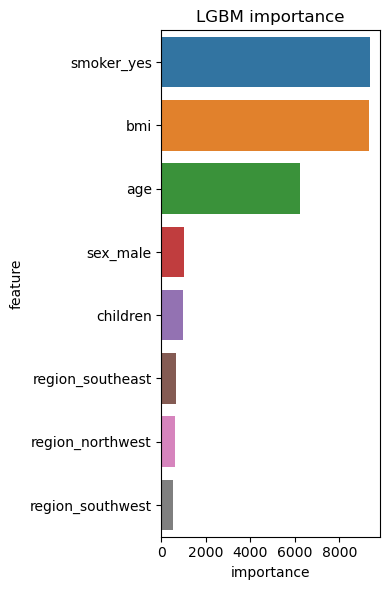

In [7]:
# 特徴量の重要度を可視化
# 特徴量重要度を保存する dataframe を用意
# https://www.sairablog.com/article/lightgbm-sklearn-kaggle-classification.html から抜粋
top_feature_num = 10
feature_importances = pd.DataFrame({
  'feature' : model.feature_name(),
  'importance': model.feature_importance(importance_type='gain'),
})

order = list(feature_importances.groupby("feature")["importance"].mean().sort_values(ascending=False).index)[:top_feature_num]

plt.figure(figsize=(4, 6))
sns.barplot(x='importance', y='feature', data=feature_importances, order=order)
plt.title('LGBM importance')
plt.tight_layout()
plt.show()

In [8]:
# Shapによる解析
# 特徴量が結果に対してどのような影響を与えたか定量的に求める(et.モデルの生成理由)

import shap

shap.initjs()
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train, check_additivity=False)


 99%|===================| 2993/3015 [00:17<00:00]        

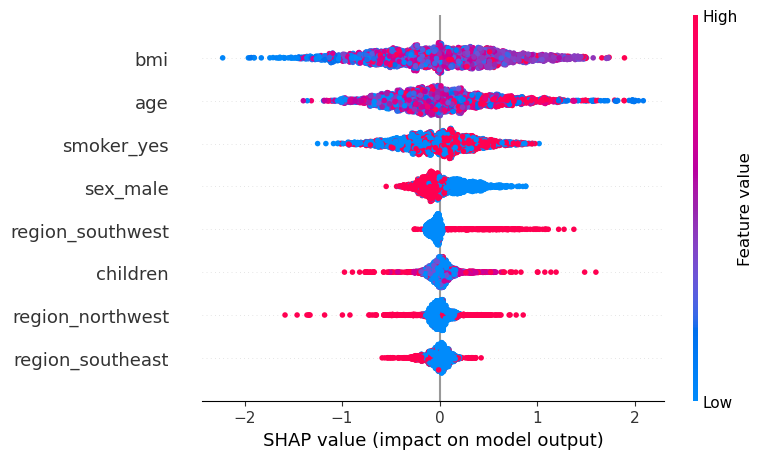

In [9]:
# summary plot
# 特徴量毎にどの程度影響を与えたか可視化(目的変数に対して、青が正の影響を、赤が負の影響を与えた事を表している)
shap.summary_plot(shap_values, X_train)

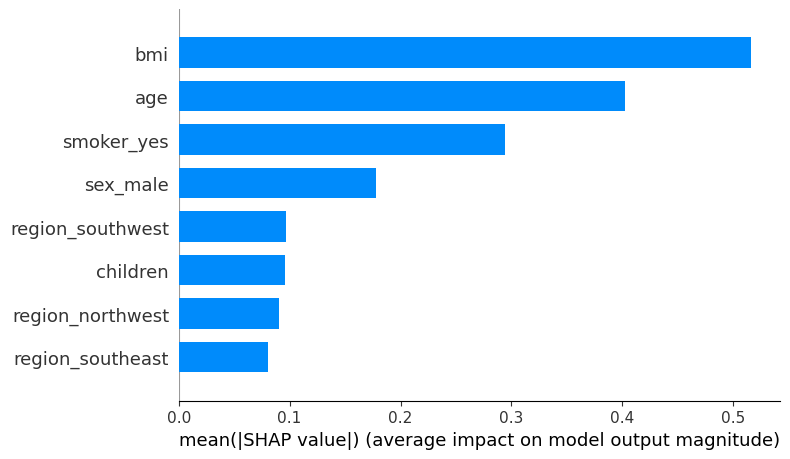

In [10]:
# 正と負のトータルとしてどのような影響を与えたか
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [11]:
# 特徴量の依存性確認
# それぞれの特徴量とSHAP値の相関関係を可視化
"""
feature_importances = pd.DataFrame({
  'feature' : model.feature_name(),
  'importance': model.feature_importance(importance_type='gain'),
})
feature_list = list(feature_importances.groupby("feature")["importance"].mean().sort_values(ascending=False).index)
for feature in feature_list:
  shap.dependence_plot(feature, shap_values.values, X_train)
  """

'\nfeature_importances = pd.DataFrame({\n  \'feature\' : model.feature_name(),\n  \'importance\': model.feature_importance(importance_type=\'gain\'),\n})\nfeature_list = list(feature_importances.groupby("feature")["importance"].mean().sort_values(ascending=False).index)\nfor feature in feature_list:\n  shap.dependence_plot(feature, shap_values.values, X_train)\n  '